In [4]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from data_normalizer import unscale_data_with_minmax
from sklearn.metrics import make_scorer
import joblib

In [5]:
filtered_data = np.load('./macroeconomic_data/filtered_data.npy', allow_pickle=True).item()

data = []

for date, data_frame in filtered_data.items():
    flattened_data = pd.json_normalize(data_frame, sep=".")
    flattened_data["10"] = str(date[1])
    data.append(flattened_data)

data = pd.concat(data, ignore_index=True)

X = data
X = X.iloc[:-1, :]

y = data.filter(regex='0.36', axis=1)  # '^0\.'
y = y.iloc[1:]
y = y.values.ravel()

random_state = np.random.RandomState()
random_state_tuple = random_state.get_state()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [6]:
base_estimator = MLPRegressor()
parameters = {'hidden_layer_sizes': [(200, 200, 200, 200, 200), (200,200,200,200), (100, 200, 200, 100), (200,200,200)],
              "activation": ['logistic', 'tanh'],
              "solver": ['sgd'], "alpha": [0.001, 0.0001, 0.00005],
              "learning_rate": ['invscaling', 'adaptive'],
              'max_iter': [100000], #'early_stopping': [True],
              'tol': [1e-6], 'momentum' : [0.8, 0.85, 0.9, 0.95], 'nesterovs_momentum': [True, False]
              }

In [7]:

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = GridSearchCV(base_estimator, param_grid=parameters, cv=5, error_score='raise', n_jobs=-1, verbose=2, scoring=mse_scorer)
clf.fit(X_train, y_train)

best_estimator = clf.best_estimator_

joblib.dump(best_estimator, './joblib/best_estimator.joblib', 3)
joblib.dump(random_state_tuple, './joblib/split_random_state.joblib', 3)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200, 200), learning_rate=invscaling, max_iter=100000, momentum=0.8, nesterovs_momentum=True, solver=sgd, tol=1e-06; total time=  39.6s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200, 200), learning_rate=invscaling, max_iter=100000, momentum=0.9, nesterovs_momentum=True, solver=sgd, tol=1e-06; total time=   4.2s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200, 200), learning_rate=invscaling, max_iter=100000, momentum=0.9, nesterovs_momentum=False, solver=sgd, tol=1e-06; total time=   2.9s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200, 200), learning_rate=invscaling, max_iter=100000, momentum=0.95, nesterovs_momentum=False, solver=sgd, tol=1e-06; total time=   0.4s
[CV] END activation=logistic, alpha=0.001, hidden_layer_sizes=(200, 200, 200, 200

['./joblib/split_random_state.joblib']

In [8]:
print(clf.cv_results_)

{'mean_fit_time': array([41.12350311, 31.87791677, 15.82412453, 17.11212902,  6.91900234,
        2.5092484 ,  0.46574597,  0.44552083,  1.11569133,  1.21403694,
        1.38117437,  1.28857274,  1.13941598,  1.05566139,  1.01972671,
        1.10436721, 18.12897735, 28.10344033, 14.42631745, 11.75051169,
        4.89591899,  4.62592955,  0.30885873,  0.29659505,  0.70347695,
        0.65323739,  0.69116845,  0.73840837,  0.67616386,  0.74734383,
        0.67274528,  0.75651202, 31.33721442, 34.70369654, 33.60727186,
       28.11940727,  9.20690656, 13.40071816,  1.44135466,  1.1174768 ,
        0.59611096,  0.58748317,  0.52304606,  0.62387938,  0.59642124,
        0.51561012,  0.52544746,  0.53271055, 18.24393129, 18.64105296,
        9.17471452, 10.0185082 ,  4.13231258,  3.08896413,  0.21234908,
        0.209869  ,  0.48787198,  0.45063415,  0.47181587,  0.46179433,
        0.4694037 ,  0.43804126,  0.46930656,  0.43961496, 27.87976537,
       18.03947906, 28.50605159, 12.92508726, 

In [9]:
try:
    best_estimator
except:
    # be sure that loaded files are not replaced by someone (potential risk)
    best_estimator = joblib.load('./joblib/best_estimator.joblib')
    random_state = np.random.RandomState()
    random_state.set_state(joblib.load('./joblib/split_random_state.joblib'))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)    

In [10]:
print(best_estimator)

MLPRegressor(activation='tanh', alpha=5e-05,
             hidden_layer_sizes=(200, 200, 200, 200), learning_rate='adaptive',
             max_iter=100000, momentum=0.85, solver='sgd', tol=1e-06)


In [11]:
y_pred = best_estimator.predict(X_test)

y_pred_scaled = unscale_data_with_minmax(np.array(y_pred))
y_test_scaled = unscale_data_with_minmax(np.array(y_test))

# Print the predicted and actual values side by side
print("Predicted\t\tActual")
for pred, actual in zip(y_pred_scaled, y_test_scaled):
    print(f"{pred}\t\t{actual}")

Predicted		Actual
99.85809289801087		100.3
99.86600431790798		100.0
100.14447066445942		99.9
99.89738723991		99.8
99.99697130535769		100.1
100.90753259353738		101.8
100.27820404641102		100.8
99.87505477467039		100.2
100.05910428932435		99.7
100.90129278960076		101.5
100.20539146303521		100.4
99.87734284792845		99.9
100.01366942913116		99.8
100.01848919151938		99.8
99.52080482686313		99.7
100.24193272955776		100.7
101.03004377422454		100.9
99.92168383319375		100.0
100.84770546142553		100.3
100.96320446360953		100.7
100.70552856319478		100.7
100.01089654865854		100.0
100.00575468515058		100.2
99.84160083419525		100.2
100.79764411075199		100.3
100.04322521334755		100.2
100.58182701733595		100.4
100.12210293343905		100.1
99.87335504663855		100.1
99.99227951064249		100.7
100.5813909544246		101.1
99.85078427415709		99.8
100.2179037607743		100.2
100.49001149331421		99.8
100.70893275360326		100.5
100.86217510631998		100.7
100.39941696946126		99.5
99.87231511330013		99.8
99.88800572694818		100.

In [12]:
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test_scaled, y_pred_scaled)
print('Mean Squared Error:', mse)
print('R-squared Score:', r2)

Mean Squared Error: 0.13820193754835708
R-squared Score: 0.43138620695993546


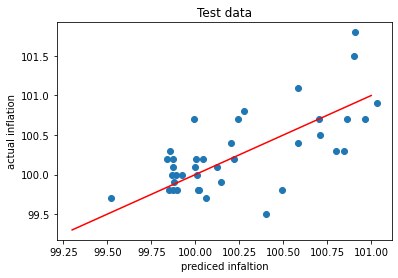

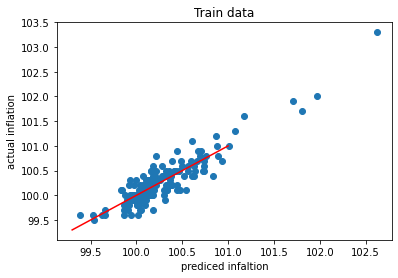

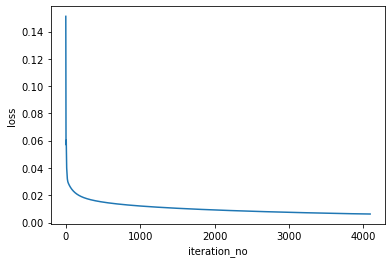

In [13]:
plt.scatter(y_pred_scaled, y_test_scaled)
plt.plot([99.3, 101], [99.3, 101], c='r')
plt.xlabel('prediced infaltion')
plt.ylabel('actual inflation')
plt.title("Test data")
plt.show()

y_train_scaled = unscale_data_with_minmax(y_train)
y_train_pred = unscale_data_with_minmax(best_estimator.predict(X_train))

plt.plot([99.3, 101], [99.3, 101], c='r')
plt.scatter(y_train_pred, y_train_scaled)
plt.xlabel('prediced infaltion')
plt.ylabel('actual inflation')
plt.title("Train data")
plt.show()

plt.figure()
plt.plot(best_estimator.loss_curve_)
plt.xlabel("iteration_no")
plt.ylabel("loss")
plt.show()

In [14]:
filtered_data_recent = np.load('./macroeconomic_data/filtered_data_recent.npy', allow_pickle=True).item()
normalized_data_recent = np.load('./macroeconomic_data/normalized_data_recent.npy', allow_pickle=True).item()

data_recent = []

for date, data_frame in filtered_data_recent.items():
    flattened_data = pd.json_normalize(data_frame, sep=".")
    flattened_data["10"] = str(date[1])
    data_recent.append(flattened_data)

data_recent = pd.concat(data_recent, ignore_index=True)

X_recent = data_recent

y_recent = []
for date, data_frame in normalized_data_recent.items():
    if 0 in data_frame:
        if 36 in data_frame[0]:
            if data_frame[0][36] is not None:
                y_recent.append(data_frame[0][36])

if (len(y_recent) > len(X_recent)):
    y_recent = y_recent[1:len(X_recent) + 1]
else:
    X_recent = X_recent.iloc[:-1, :]

    y_recent = data_recent.filter(regex='0.36', axis=1)
    y_recent = y_recent.iloc[1:]
    y_recent = y_recent.values.ravel()


y_recent_pred = best_estimator.predict(X_recent)

y_recent_scaled = unscale_data_with_minmax(np.array(y_recent))
y_recent_pred_scaled = unscale_data_with_minmax(y_recent_pred)

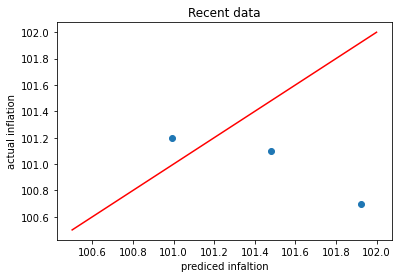

In [15]:
plt.scatter(y_recent_pred_scaled, y_recent_scaled)
plt.plot([100.5, 102], [100.5, 102], c='r')
plt.xlabel('prediced infaltion')
plt.ylabel('actual inflation')
plt.title("Recent data")
plt.show()